#### 이 것은 안드레이룩야넨코의 노트북을 한글화 한 것입니다

## General information

Don't Overfit II 에서는 바이너리 클래시피케이션을 합니다

300열 250행의 훈련 샘플에 테스트 샘플은 79배나 됩니다	

이런 상황에서 오버핏하기 쉬운데 훈련세트가 작기 때문입니다	

오버피팅의 의미가 생각 안 나시면 간단히 말해서 트레이닝 데이터에는 잘 맞으나 테스트 데이터에는 잘 맞지 않는다는 이야기 입니다	

우리는 오버피팅하지 않는 모델을 만들어야 합니다

이 노트에서는 다음을 합니다

* 인사이트를 얻기위해 항목에 대한 EDA를 합니다
* 퍼뮤테이션 임포턴스를 사용하여 가장 영향력 있는 항목을 찾습니다	
* 여러 모델을 비교합니다 - 베이스 클래시피케이션, 리니어 모델, 트리기반 모델 등을 해봅니다
* 여러 종류의 feature selection 방법을 해봅니다 - ELI5 및 SHAP을 포함합니다
* 모델 하이퍼 파라미터 최적화를 해봅니다
* 항목 생성을 해봅니다
* 그리고 다른 여러가지를 해보지요

![](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)

In [ ]:
# Libraries
import numpy as np
import pandas as pd
from scipy import stats
pd.set_option('max_columns', None)
import json
import ast
import time
import datetime
import os
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# 정우일님의 관련 블로그 https://wooiljeong.github.io/python/python_plotly/

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFECV


import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier

from sklearn import linear_model
import statsmodels.api as sm

import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/kaggle/input/dont-overfit-ii'
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')
train.shape

(250, 302)

In [ ]:
test.shape

(19750, 301)

구글 콜랩에서 사용하실 때는 컴퓨터에 첨부된 트레인 및 테스트 csv 파일을 컴퓨터에 다운로드 한 후 아래 코드를 실행하여 다시 그 파일들을 불러올 수 있게 됩니다.

    from google.colab import files
    uploaded = files.upload()

그런 다음 아래 코드를 통해서 csv를 데이터프레임으로 바꿀 수 있게 됩니다.

    import io
    test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
    train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

<a id="de"></a>
## Data exploration

In [ ]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,1.359,-0.177,0.406,-0.163,1.341,0.754,0.491,-1.560,-0.520,0.766,0.216,-0.510,0.101,-0.602,-0.721,-0.545,1.564,2.003,-1.940,1.285,-0.987,-1.370,1.373,-0.495,0.113,-0.523,0.053,-0.888,0.249,0.687,1.363,0.169,-1.122,1.209,0.891,0.866,0.847,-1.110,1.224,-1.302,-1.647,-0.091,0.255,0.730,-0.380,0.294,-0.725,0.844,1.002,-1.267,-0.043,1.158,0.779,-0.733,-0.501,1.841,1.459,0.847,1.926,-0.316,0.044,-0.294,0.120,-1.050,0.730,-1.001,-0.321,0.407,0.469,0.445,1.632,0.273,1.557,1.196,-0.548,-0.275,0.179,0.584,-1.873,0.928,0.720,0.885,0.044,-1.131,-1.576,0.616,1.957,-0.518,1.494,1.573,-0.484,0.590,-0.387,0.388,-1.032,-0.841,0.288,-0.230,-2.714,-0.473,0.476,-1.352,-0.922,0.329,-0.558,0.787,-1.043,-0.130,0.517,2.445,0.847,-0.636,-0.324,0.753,0.058,-1.461,-0.820,-0.076,1.127,-0.496,1.020,0.279,0.262,-0.277,-0.166,-0.089,-1.696,-0.598,-0.710,-0.431,0.355,0.966,-1.150,-0.156,0.393,-0.117,0.444,0.948,-0.608,-0.106,-0.491,-0.608,1.565,1.013,-1.391,0.807,-0.607,-0.856,1.230,0.124,-0.336,1.758,-1.649,-1.429,-1.322,-1.501,2.125,-0.572,1.178,-1.451,-0.374,2.386,1.883,0.758,0.295,1.261,-0.837,0.140,-0.183,0.756,0.616,1.371,0.820,-0.702,-1.266,0.496,-0.669,-0.325,-0.170,0.147,-1.134,0.077,1.271,-0.087,-1.431,1.640,0.694,0.949,-2.400,0.657,-0.431,0.124,-0.335,-2.820,0.573,-0.755,3.798,-0.001,0.998,-0.543,1.018,0.883,-1.037,0.513,0.694,0.856,-0.523,0.596,0.971,0.279,2.684,-0.057,-1.754,0.297,-2.196,0.798,-0.533,-0.661,0.564,-2.400,0.945,-0.971,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,1.125,0.279,-0.682,1.161,1.194,0.243,1.179,1.338,-1.000,-0.362,-0.605,1.917,-1.157,0.394,-0.482,1.591,0.106,-0.959,0.600,-1.147,-1.064,3.080,1.057,0.947,-1.125,1.288,-0.171,1.124,-0.454,0.698,-0.028,2.208,0.014,0.872,2.286,-0.822,0.416,1.486,-0.331,-0.993,-0.071,0.543,-0.096,0.041,0.138,1.110,0.692,1.407,-0.234,-1.899,-0.131,0.934,0.802,-1.041,2.004,1.424,0.423,-0.352,-0.656,-0.053,1.036,-1.228,-0.854,-0.748,1.180,0.575,-1.472,-1.215,-0.889,0.004,-0.145,-0.933,-0.713,0.869,0.539,-0.911,-0.638,0.895,-1.896,-0.604,0.312,1.883,-0.292,-0.849,-0.453,0.894,0.339,2.095,0.336,1.290,0.057,-0.159,0.539,0.675,-1.015,-0.304,-1.301,-0.614,-1.176,0.117,0.075,-0.088,1.888,-0.119,0.434,0.135,1.779,0.5

* id 열, target 열 및 300개의 항목이 있음을 알 수 있습니다
* 익명으로 처리되었으므로 그 의미를 모릅니다
* 열들에 대해 이해하려고 노력해보지요

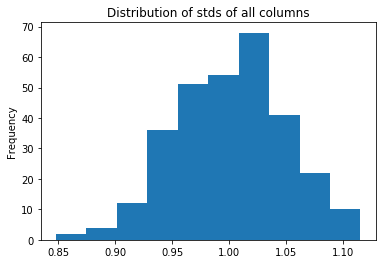

In [ ]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

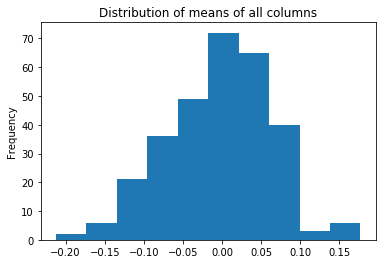

In [ ]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

* 모든 열의 평균 값이 -0.2와 0.15 사이임을 알 수 있습니다	
* 표준 편차는 매우 작습니다
* 우리는 항목이 서로 매우 비슷하다고 말할 수 있습니다

In [ ]:
# we have no missing values
train.isnull().any().any()

False

Distributions of first 28 columns


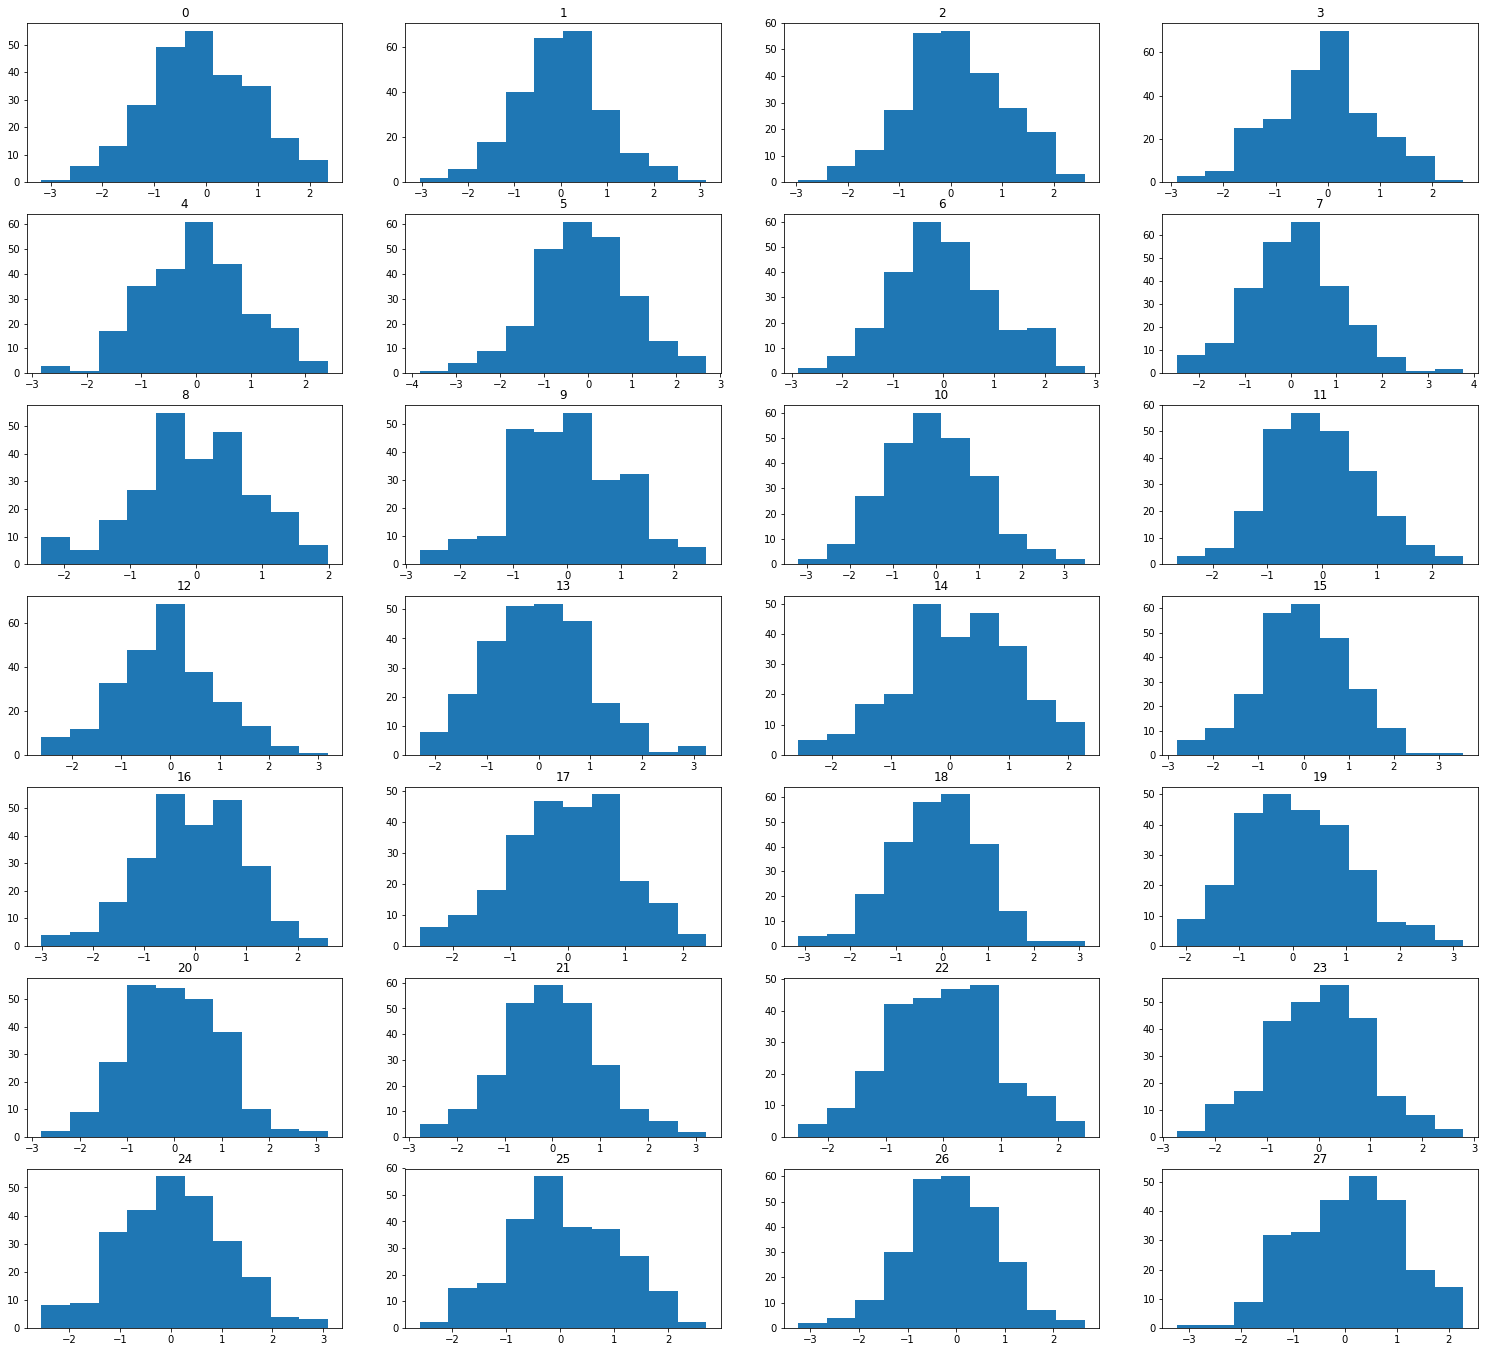

In [ ]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [ ]:
train['target'].value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

이 개요에서 우리는 다음을 볼 수 있습니다

* 대상은 이진이며 약간의 불균형이 있습니다
* 샘플의 26.8 %가 0 클래스에 속합니다
* 열의 값은 다소 비슷합니다

이제 상관 관계를 살펴 봅시다!

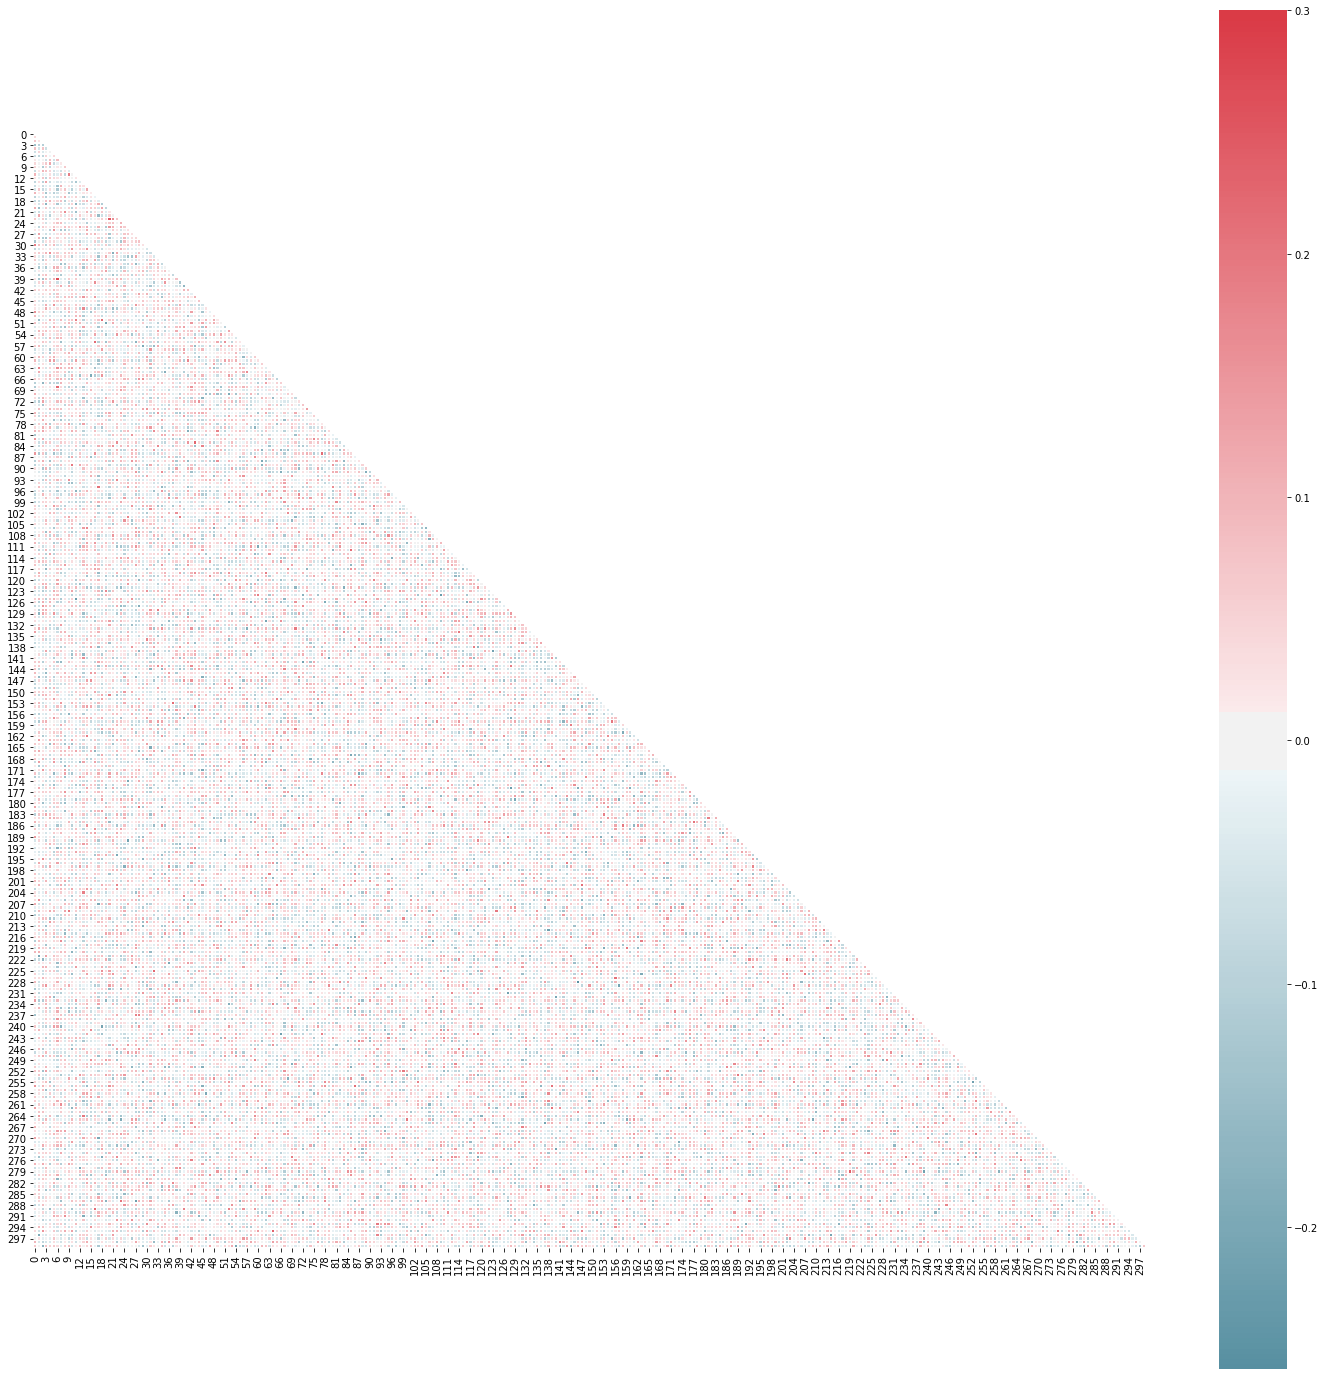

In [ ]:
corr = train[train.columns[2:]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

열이 너무 많아서 위에서 도저히 읽을 수가 없습니다.

top correlated features를 보겠습니다.

In [ ]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540


항목 간의 상관 관계가 0.3보다 낮고 target과 가장 관련이 높은 피처의 상관 관계는 03.3입니다	

따라서 제거 할 수 있는 상관 관계가 높은 항목이 없으며	target과 상관 관계가 거의 없는 일부 열을 삭제할 수 있습니다

## Prepare the data

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)

#민지

"교차검증"
cross validation
: 데이터 개수가 적을때 fold out 평가의 낮은 신뢰성 문제를 해결하기 위해서 훈련 데이터 셋과 테스트 데이터 셋을 여러번 만들어 학습-예측을 여러번 수행하고 평균 정확도를 구하는 평가방식
-> 교차검증을 통해 좀 더 신뢰성있는 검사를 할 수 있다

<종류>
1. k-fold cross validation
2. shuffle split cross validation
3. leave-one-out cross validation
4. leave-p-out cross validation

# Basic modelling

기본 모델링을합니다

훈련 모델과 폴드 예측에 익숙해지기를 바랍니다	

이것이 왜 유용할까요?

sklearn의 cross_val_score는 모델의 점수를 계산하기에 충분하지만, 자세히 배울수록 충분하지는 않다는 것을 알게 될 것입니다	but as you learn more, you'll realize it isn't always enough

왜냐하면	

* 예측을 제공하지 않습니다
* 폴드로부터의 예측은 제공하지 않습니다
* 특정 변환을 적용할 수 없습니다
* lgbm, catboost, xgboost와 같은 그래디언트 부스팅 모델은 cross_val_score로 전달할 수 없는 추가 매개 변수를 필요로 합니다	

이 것은 어렵지 않고 논리는 다음과 같습니다

```
for fold in folds:
    get train and validation data
    apply some transformations (if necessary)
    train model
    predict on validation data
    calculate train and validation metrics
    predict on test data
```

간단한 로지스틱 리그레션을 사용하여 단계별로 코드를 작성해 봅시다

[](http://i.imgur.com/QBuDOjs.jpg)

먼저 몇 가지 사항을 정의 해 보겠습니다	

* Prediction은 우리의 예측이 될 것입니다
* scores_train, scores_valid은 점수 리스트입니다
* fold란 데이터를 나누는 방법입니다

In [ ]:
prediction = np.zeros(len(X_test))
scores_train = []
scores_valid = []
folds = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
# n_split 20 -> 20개의 폴드가 있다
# random_state = 42 42로 하는게 관행임

이제 폴드를 한 번 사용하여 트레인 데이터를 훈련 및 검증으로 분할합니다

In [ ]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_fold, X_valid_fold = X_train.loc[train_index], X_train.loc[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
    break

이제 모델을 훈련시키고 메트릭을 계산할 수 있습니다

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model.fit(X_train_fold, y_train_fold)
y_pred_train = model.predict(X_train_fold).reshape(-1,)
train_score = roc_auc_score(y_train_fold, y_pred_train)

y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
valid_score = roc_auc_score(y_valid_fold, y_pred_valid)


In [ ]:
print(f'Train auc: {train_score:.4}. Valid auc: {valid_score:.4}')

Train auc: 0.883. Valid auc: 0.725


함수를 만들어 봅니다

이는 테스트데이터에 대한 예측도 만들 수 있는 것입니다

In [ ]:
def train_model(X_train, y_train, X_test, folds=folds, model=None):
    prediction = np.zeros(len(X_test))
    scores_train = []
    scores_valid = []
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_train = model.predict(X_train_fold).reshape(-1,)
        train_score = roc_auc_score(y_train_fold, y_pred_train)
        scores_train.append(train_score)
        
        y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
        valid_score = roc_auc_score(y_valid_fold, y_pred_valid)
        scores_valid.append(valid_score)

        y_pred = model.predict_proba(X_test)[:, 1]
        prediction += y_pred

    prediction /= folds.get_n_splits()
    
    print(f'Mean train auc: {np.mean(scores_train):.4f}, std: {np.std(scores_train):.4f}.')
    print(f'Mean valid auc: {np.mean(scores_valid):.4f}, std: {np.std(scores_valid):.4f}.')
    
    return scores_valid, prediction


In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds,  model=model)

Mean train auc: 0.8780, std: 0.0105.
Mean valid auc: 0.6871, std: 0.0995.


### Different ways of splitting data into folds

데이터를 폴드로 나누는 방법에는 여러 가지가 있습니다
* 가장 간단한 방법은 무작위로 나누는 것입니다: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
* 일반적으로 분류에는 더 나은 방법이 있긴 합니다 - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html 

StratifiedKFold는 계층화 된 폴드를 반환하는 k-폴드의 변형입니다

각 세트에는 각 세트의 샘플이 전체 세트와 거의 같은 비율로 포함되어 있습니다

* StratifiedKFold와 비슷한 RepeatedStratifiedKFold도 있는데 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html 이는 그 안에서 여러번 반복됩니다

우리는 RepeatedStratifiedKFold로 확인하겠습니다

k
k-1 -> 트레인 셋
1 -> 테스트 셋
k번 횟수만큼 교차검증을 반복
k=5면 정확도가 5개 -> 그거의 평균

##k fold
k=5일때 랜덤으로 트레인 세트를 5조각으로 나누어 4개는 트레인용 1개는 교차검증용으로 사용

##k fold cross validation 
##k 폴드 교차 검증
k=5, 5세트를 만들면 4세트가 학습 데이터(train 용)가 되고 5번째 세트는 유효성 검사(교차 검증용)를 위한것 

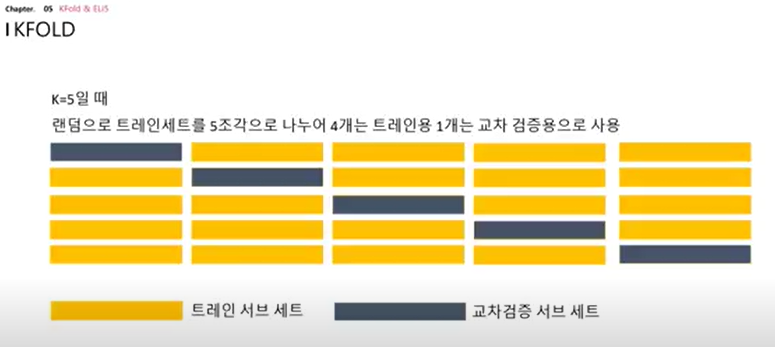

이렇게 총 5개의 모델 또는 k 모델이 k번 교차 검증을 한다

##startified K Fold
계층화 k겹 교차등급
: 계층화된 폴드를 반환하는 k 폴드의 변형이다
-> 데이터가 편향되면 k 폴드 교차 검증이 제대로 수행되지 않을 수 있다 -> 그래서 트레인 세트와 유효성 검사 세트를 여기저기서 수집함

각세트에는 각 세트의 샘플이 전체 세트와 거의 같은 비율로 포함되어잇음

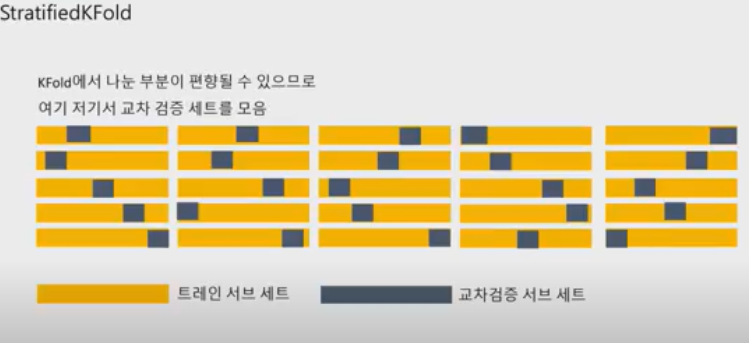

kFold에서 나눈 부분이 편향될 수 있으므로 
사진처럼 여기저기서 수집함

일반적으로 kFold는 회귀에서 사용하고
startifiedKFold는 분류에 사용된다


##Repeated Stratified K Fold
: startifiedKFold와 비슷함 얘는 그 안에서 반복됨
-> 각 반복마다 또 랜덤으로 n번 반복
"교차검증 내부에 교차검증이 있다"


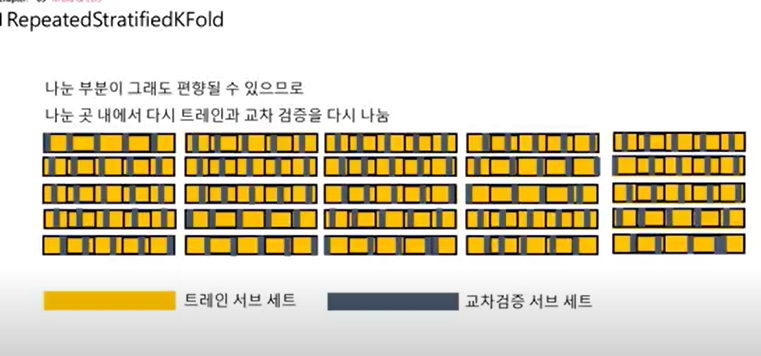

In [ ]:
#repeated stratified K fold
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=42)
#n_splits 는 정수값이고 기본값은 5 (fold의 개수)
#n_repeats 교차검증을 반복해야하는 횟수
#randomState=42

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds, model=model)

Mean train auc: 0.8776, std: 0.0122.
Mean valid auc: 0.7124, std: 0.1360.


mean auc가 증가한 것을 볼 수 있습니다

## Approaches to feature selection

feature selection이 무엇이고 왜 중요한지 설명하겠습니다

# 혜빈
eli5: 항목의 중요도를 보여주고 의사결정 트리, 트리기반 앙상블 예측, 각 항목이 최종 결과에 얼마나 기여했는지

랜덤 포레스트 -> 블랙박스 , 큰 영향력을 미치는 항목이 무엇인지 모름=> 개별 트리를 검사하여 의사결정 프로세스를 완전히 이해하는 것은 불가능함, 랜덤포레스트는 항목중요도로 계산함, 모델 성능 변경 확인(불순물양 계산), 약간의 인사이트?-> eli5는 화이트 박스임

항목선택에 대한 접근 법, 머신러닝 모델에 대, 한 설명을 제공, 디버깅 예측 설명
분류, 회귀
선형 모델이나 랜덤포레스트 lightgbm-> 트리 기반 알고리즘에서도 수행
통합 api  머신러닝모델 시각화 및 디버깅 -> python 라이브러리
여러 ml프레임워크 지원 - 블랙박스 모델 설명
블랙박스: 알고리즘이 뭔가를 넣으면 결과가 나오지만 무슨 일이 일어나는지 모를 때 <-> 왜 이런 결과가 나왔는지 볼 수 있게 어떤 항목이 중요했는지를 볼 수 있다. 
scikit-learn linear classifier 선형 분류, 회귀의 가중치 예측 설명
의사 트리 및 트리 기반 앙상블의 항목 중요도 예측 및 설명 가능
모델 매개 변수를 검사하고 어떻게 작동하는지 파악
show_weights 어떤기능이 얼마나 많 가중치를 가지고 있는지
weights가 +인 부분 50개 -인 부분이 더 많음
eli5에서 따르는 중요한 항목은 32개 -> 모델을 구축
top_features를 지정하여 주요 항목 리스트
매우 간단하게 작동: 로지스틱 회귀 모델 계수 보여줌, 랜덤 포레스트의 항목 중요도
각 항목의 계수 값이 표시-> 항목중요도가 없는 경우 eli5가 작동 하지 않음->SVC-> 표시를 하기 위해 x train 과 test를 top 항목에 넣음
auc (곡선 아래 2차원 영역), 표준편차 
=> 데이터에서 영향력이 없는 것은 빼는 과정 


### ELI5

ELI5는 ML 모델에 대한 설명을 제공하는 패키지입니다	

선형 모델뿐만 아니라 트리 기반 알고리즘에 대해서도 이를 수행 할 수 있습니다

In [ ]:
eli5.show_weights(model, top=50)

Weight?,Feature
+0.597,x127
+0.231,x18
+0.210,x241
+0.146,x66
+0.104,x213
+0.100,x261
+0.096,x178
+0.084,x3
+0.037,x260
+0.028,x93


In [ ]:
(model.coef_ != 0).sum()

32

가중치가 매우 높은 항목과 가중치가 마이너스인 더 많은 항목이 있음을 알 수 있습니다	

실제로 ELI5에 따르면 중요한 항목은 32개만 있습니다	

이 항목들만 사용하여 모델을 구축해 봅시다

In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]

Important information about ELI5:

실제로 매우 간단하게 작동됩니다	
logistic regression와 같은 모델의 model coefficient를 보여주거나 랜덤 포레스트와 같은 모델의 feature importance를 보여 줍니다	

ELI5의 결과를 model coefficient와 비교해 봅니다

In [ ]:
for i, coef in enumerate(model.coef_[0]):
    if coef != 0:
        print(f'Feature {X_train.columns[i]} has coefficient {coef:.4f}')

Feature 3 has coefficient 0.0842
Feature 16 has coefficient -0.1632
Feature 18 has coefficient 0.2311
Feature 26 has coefficient 0.0096
Feature 59 has coefficient -0.1603
Feature 63 has coefficient -0.0049
Feature 66 has coefficient 0.1465
Feature 69 has coefficient -0.0881
Feature 74 has coefficient -0.0932
Feature 80 has coefficient -0.0833
Feature 93 has coefficient 0.0276
Feature 113 has coefficient -0.1226
Feature 126 has coefficient -0.0930
Feature 127 has coefficient 0.5974
Feature 133 has coefficient -0.1412
Feature 134 has coefficient -0.0212
Feature 135 has coefficient -0.2127
Feature 136 has coefficient -0.0046
Feature 159 has coefficient -0.0535
Feature 176 has coefficient -0.2947
Feature 177 has coefficient -0.0328
Feature 178 has coefficient 0.0962
Feature 189 has coefficient -0.0316
Feature 199 has coefficient -0.1683
Feature 200 has coefficient -0.1118
Feature 208 has coefficient 0.0233
Feature 213 has coefficient 0.1045
Feature 241 has coefficient 0.2099
Feature 260 ha

여기에 중요한 결론이 있습니다

모델에 계수 또는 항목 중요도가 없는 경우 ELI5가 작동하지 않습니다	

SVC가 그런 예입니다	

In [ ]:
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=model)

Mean train auc: 0.8690, std: 0.0123.
Mean valid auc: 0.7526, std: 0.1311.


모델이 훨씬 좋아졌다는 것을 알 수 있습니다

중요한 교훈은 때로는 영양가 없는 것은 없는 것이 좋다는 것이죠

<a id="eli5p"></a>
### Permutation importance

ELI5를 잘 이용하는 다른 방법이 하나 더 있습니다

Permutation Feature Importance는 데이터가 테이블 형식일 때 훈련된 estimator에 사용할 수 있는 모델 검사 기술입니다	 

Permutation Importance는 다음과 같은 방식으로 작동합니다	

* 모델을 훈련 시킵니다
* 하나의 유효성 검사 데이터 열을 무작위로 섞고 점수를 계산합니다
* 점수가 크게 떨어지면 항목이 중요하다는 의미입니다

링크를 클릭하시면 추가적으로 내용을 볼 수 있습니다: https://www.kaggle.com/dansbecker/permutation-importance

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds,  model=model)

Mean train auc: 0.8776, std: 0.0121.
Mean valid auc: 0.7124, std: 0.1360.


In [ ]:
submission = pd.read_csv(f'{path}/sample_submission.csv')
submission['target'] = prediction
submission.to_csv('submission_3.csv', index=False)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

Weight,Feature
0.0896 ± 0.0665,x127
0.0256 ± 0.0082,x133
0.0248 ± 0.0199,x176
0.0184 ± 0.0224,x74
0.0160 ± 0.0182,x261
0.0152 ± 0.0245,x113
0.0136 ± 0.0193,x18
0.0120 ± 0.0196,x178
0.0104 ± 0.0165,x135
0.0104 ± 0.0148,x80


In [ ]:
eli5.formatters.as_dataframe.explain_weights_df(perm).head()

,feature,weight,std
0,x127,0.0896,0.033236
1,x133,0.0256,0.004079
2,x176,0.0248,0.009928
3,x74,0.0184,0.011200
4,x261,0.0160,0.009121


In [ ]:
eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0].shape

(32, 3)

In [ ]:
selected_weights = eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0]

In [ ]:
top_features = [i[1:] for i in selected_weights.feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=model)

Mean train auc: 0.8690, std: 0.0123.
Mean valid auc: 0.7526, std: 0.1311.


# 수민
 
 ### shap이란?
- 블랙박스 모델의 예측 결과를 설명하기 위한 매소드이다. 
 최근에 많이 쓰는 DNN, 로지스틱, 그래디언트 부스팅 모델등은 블랙박스 모델인데, 이러한 모델에서 결과를 해석하고 '왜'이러한 결과가 나왔는지 설명해주기 위하여 shap같은 메소드를 사용한다. 

 ### 유래?
 - 게임이론 중 shapley values에 기초하여 나왔다. 
shapley values는 각 공헌자가 얼마나 공헌했는지 나타내는 수치이다. 협력과 비협력에 따른 영향을 계산한다. 

 ### 문제점? 
 - 변수간 높은 상관관계에 취약하다 

 참고) https://shap-lrjball.readthedocs.io/en/latest/index.html


### SHAP

또 다른 흥미로운 도구는 SHAP입니다	

다양한 모델에 대한 설명을 제공합니다

In [ ]:
# 모델생성(로지스틱회귀모델)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
# 모델 예측
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds, model=model)

Mean train auc: 0.8776, std: 0.0122.
Mean valid auc: 0.7124, std: 0.1360.


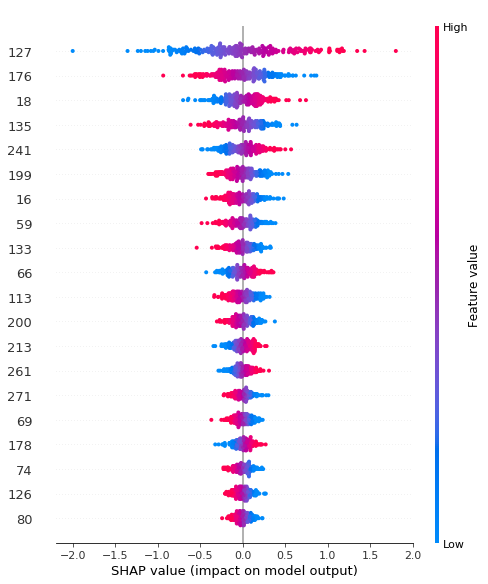

In [ ]:
# shap.LinearExplainer(model, data, nsamples=1000, feature_perturbation=None, **kwargs)
# model(coef, intercept) or sklearn.linear_model
# sklearn의 linear_model에 로지스틱 회귀로 모델을 생성해서 LinearExplainer메소드를 사용한다
explainer = shap.LinearExplainer(model, X_train)
# shap_values은 Estimate the SHAP values for a set of samples.
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


이 플롯을 처음 볼 때 해석하기 어려울 수 있습니다

항목이 예측에 미치는 영향을 보여줍니다	

각 행은 각 항목을 나타냅니다	

색상은 실제 항목 값입니다	

예를 들어 파란색  항목 18의 낮은 값은 모형 예측에 부정적인 영향을 미칩니다 (1이냐 0이냐에서 0이 되겠지요)	

빨간색인 높은 값은 긍정적인 영향을 미칩니다 (1이냐 0이냐에서 1이 되겠지요)

항목 176은 반대 영향이 있습니다 	

낮은 값은 긍정적인 영향을 미치며 높은 값은 부정적인 영향을 미칩니다	

불행히도 항목을 수동으로 선택해야합니다 	

그 작업을 해주는 라이브러리를 사용하겠습니다	

### Recursive feature elimination



In [ ]:
def train_model_with_feature_selection(X_train, y_train, X_test, folds=folds, model=None, feature_selector=None):
    prediction = np.zeros(len(X_test))
    scores_train = []
    scores_valid = []
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        # so that we don't transform the original test data
        X_test_copy = X_test.copy()
        
        feature_selector.fit(X_train_fold, y_train_fold)
        X_train_fold = feature_selector.transform(X_train_fold)
        X_valid_fold = feature_selector.transform(X_valid_fold)
        X_test_copy = feature_selector.transform(X_test_copy)
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_train = model.predict(X_train_fold).reshape(-1,)
        train_score = roc_auc_score(y_train_fold, y_pred_train)
        scores_train.append(train_score)
        
        y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
        valid_score = roc_auc_score(y_valid_fold, y_pred_valid)
        scores_valid.append(valid_score)

        y_pred = model.predict_proba(X_test_copy)[:, 1]
        prediction += y_pred

    prediction /= folds.get_n_splits()
    
    print(f'Mean train auc: {np.mean(scores_train):.4f}, std: {np.std(scores_train):.4f}.')
    print(f'Mean valid auc: {np.mean(scores_valid):.4f}, std: {np.std(scores_valid):.4f}.')
    
    return scores_valid, prediction


우리 버전의 수정된 버전을 작성해 봅니다	

여기 교차 교차 데이터 내에 RFECV를 추가합니다

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
feature_selector = RFECV(model, min_features_to_select=10, scoring='roc_auc', step=0.1, verbose=0, cv=repeated_folds, n_jobs=-1)
scores, prediction = train_model_with_feature_selection(X_train.values, y_train, X_test, folds=repeated_folds, model=model, feature_selector=feature_selector)

Mean train auc: 0.8736, std: 0.0198.
Mean valid auc: 0.7071, std: 0.1405.


# 성윤

### Comparing models

다른 모델을 비교할 수 있습니다 

기본 매개 변수가있는 모델이 제대로 작동하지 않을 수 있으므로 최적화 된 모델을 비교할 가치가 있다고 생각합니다	

다음과 같이 할 것입니다:

* default parameter로 모델을 학습하고 기본 점수를 확인합니다	 
* best feature들을 선택합니다	 
* grid search를 실행합니다 
* best model을 훈련시키고 다시 점수를 봅니다	

또한 각 모델에 대한 feature selection을 해봅니다  

그리고 훈련을 더 빠르게 하기 위해 반복하지 않는 간단한 폴드를 사용할 것입니다

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.8780, std: 0.0105.
Mean valid auc: 0.6871, std: 0.0995.

Best score of GridSearchCV: 0.9434
Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Mean train auc: 0.8908, std: 0.0096.
Mean valid auc: 0.8515, std: 0.1138.


모델을 최적화하면 실제로 auc 점수가 향상됩니다!

In [ ]:
model = AdaBoostClassifier()
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]


abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_abc, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 1.0000, std: 0.0000.
Mean valid auc: 0.5199, std: 0.1136.

Best score of GridSearchCV: 0.7069444444444444
Best parameters: {'learning_rate': 0.1, 'n_estimators': 10}

Mean train auc: 0.5040, std: 0.0113.
Mean valid auc: 0.4994, std: 0.0055.


3. SGD Classifier (Stochastic Gradient Descent) (확률적 경사하강법)

- liblinear 라이브러리를 사용한다.
- ML을 수행할 데이터가 대용량일 때 사용한다.
- 확률적 모델로 접근한다.
- Gradient Descent는 batch에 전체 data set을 사용한다.
  - Batch란 (일괄적으로 처리되는)집단으로, 한번에 여러개의 데이터를 묶어서 입력하는 것.
  - GPU 의 병렬 연산 기능을 최대한 효율적으로 사용하기 위해 쓰는 방법



In [ ]:
model = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001, loss='modified_huber')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01, 0.1, 0.5],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_sgd, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.9921, std: 0.0090.
Mean valid auc: 0.5768, std: 0.1370.

Best score of GridSearchCV: 0.7896444444444445
Best parameters: {'alpha': 0.1, 'l1_ratio': 1.0, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'penalty': 'elasticnet'}

Mean train auc: 0.8363, std: 0.0177.
Mean valid auc: 0.6387, std: 0.1337.


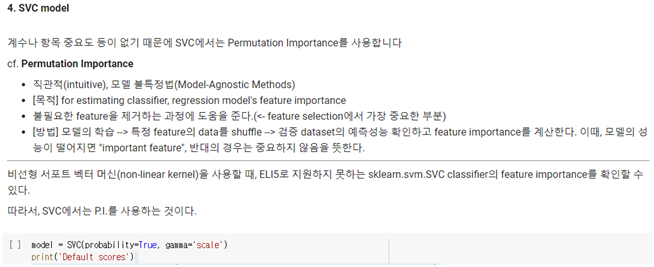

In [ ]:
model = SVC(probability=True, gamma='scale')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
selected_weights = eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0]
top_features = [i[1:] for i in selected_weights.feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_svc, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.9678, std: 0.0134.
Mean valid auc: 0.5000, std: 0.0000.

Best score of GridSearchCV: 0.704
Best parameters: {'C': 10.0, 'kernel': 'rbf'}

Mean train auc: 1.0000, std: 0.0000.
Mean valid auc: 0.5084, std: 0.0567.


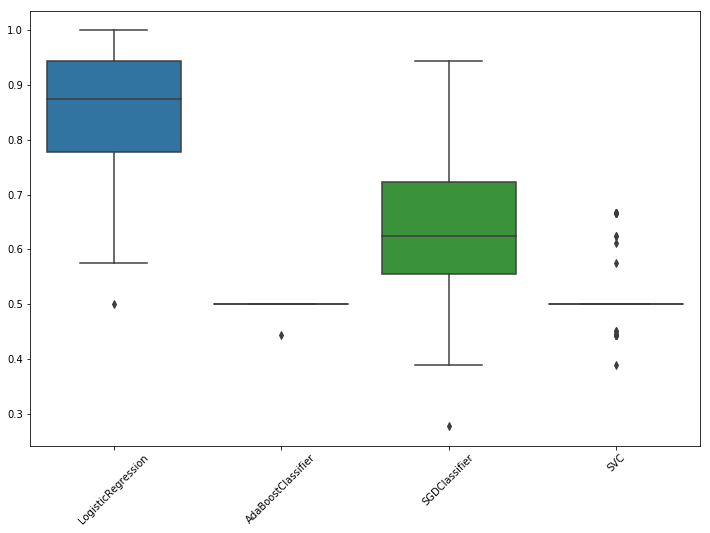

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores_logreg})
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['SGDClassifier'] = scores_sgd
scores_df['SVC'] = scores_svc

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

logistic regression가 대부분의 다른 모델보다 우수하다는 것을 알 수 있습니다 

다른 모델은이 작은 데이터 세트에서 과적합하거나 작동하지 않는 것 같습니다 

## Feature engineering

항목 생성에는 여러 접근 방식이 있습니다	

익명화되고 비슷한 항목들이 있으면 행을 기준으로 항목을 계산할 수 있습니다

예를 들어 행 별 평균값 같은 것을 말합니다

In [ ]:
X_train['mean'] = X_train.mean(axis=1)
X_train['kurt'] = X_train.kurt(axis=1)
X_train['mad'] = X_train.mad(axis=1)
X_train['median'] = X_train.median(axis=1)
X_train['max'] = X_train.max(axis=1)
X_train['min'] = X_train.min(axis=1)
X_train['skew'] = X_train.skew(axis=1)
X_train['sem'] = X_train.sem(axis=1)

X_test['mean'] = X_test.mean(axis=1)
X_test['kurt'] = X_test.kurt(axis=1)
X_test['mad'] = X_test.mad(axis=1)
X_test['median'] = X_test.median(axis=1)
X_test['max'] = X_test.max(axis=1)
X_test['min'] = X_test.min(axis=1)
X_test['skew'] = X_test.skew(axis=1)
X_test['sem'] = X_test.sem(axis=1)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = itemgetter([int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i])(X_train.columns)
X_train_selected = X_train[top_features]
y_train = train['target']
X_test_selected = X_test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.8925, std: 0.0105.
Mean valid auc: 0.6932, std: 0.1074.

Best score of GridSearchCV: 0.9477333333333331
Best parameters: {'C': 0.05, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Mean train auc: 0.8866, std: 0.0057.
Mean valid auc: 0.8192, std: 0.1278.


CV 점수를 향상시키지 않았으므로 이러한 항목이 크게 도움이 되지 않은 것 같습니다

## Scaling the data

마지막 요령은 데이터의 크기를 조정하는 것입니다

일반적으로 다음과 같은 접근 방식이 있습니다

* 각 폴드에서 데이터를 트레인과 검증용으로 나눈 다음 
* 트레인데이터 및 검증데이터에 스케일러를 적용한 후 
* 다시 검증 및 테스트에 적용하는 것입니다	
* 앞처럼 다시 진행해 봅니다	

그러나 Kaggle에서는 테스트 데이터를 즉시 적용할 수 있는 독특한 상황입니다	

따라서 사용 가능한 모든 데이터에 스케일러를 적용해보기도 합니다	

데이터를 다시 준비하고 stanard scaler를 사용합니다

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)

In [ ]:
sc = StandardScaler()
data = StandardScaler().fit_transform(np.concatenate((X_train, X_test), axis=0))
X_train.iloc[:, :] = data[:250]
X_test.iloc[:, :] = data[250:]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = itemgetter([int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i])(X_train.columns)
X_train_selected = X_train[top_features]
y_train = train['target']
X_test_selected = X_test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

In [ ]:
submission = pd.read_csv(f'{path}/sample_submission.csv')
submission['target'] = prediction
submission.to_csv('submission.csv', index=False)

점수가 조금 증가했습니다!